# goes-orthorectify

Orthorectify and clip a GOES ABI image using an input DEM

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import goes_ortho

#### Pick an ABI image and a DEM

* The DEM I'm using here is merged/cropped around the upper Tuolumne River basin and includes Mammoth Mountain, from four tiles of [SRTM, 1 Arc-Second Global](https://www.usgs.gov/centers/eros/science/usgs-eros-archive-digital-elevation-shuttle-radar-topography-mission-srtm-1-arc?qt-science_center_objects=0#qt-science_center_objects) retrieved from [USGS EarthExplorer](https://earthexplorer.usgs.gov/).

In [2]:
image_path =  r'\\j-lundquist-3.ce.washington.edu\storage\GOES\goes16\2020\06\30\ABI-L1b-RadC\17\C14\OR_ABI-L1b-RadC-M6C14_G16_s20201821701177_e20201821703550_c20201821704054.nc'

dem_filename = 'dem\dem2.tif' # local file

Open each and preview them

Orbital Slot: GOES-East

Satellite subpoint:
	Latitude: 0.0
	Longitude: -75.0

Orbital height (m): 35786023.0


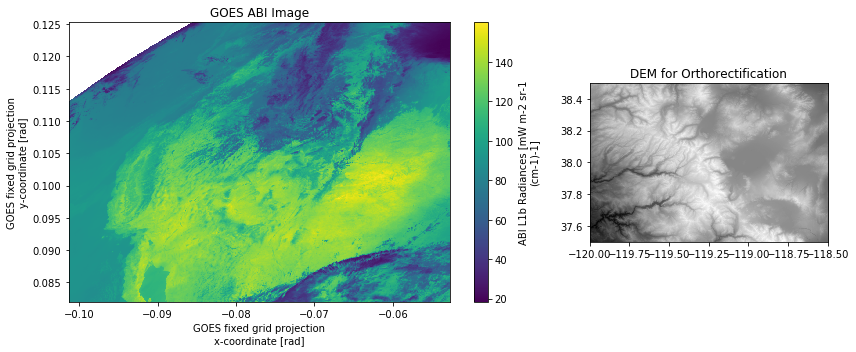

In [3]:
# open GOES ABI image to preview it
goes_abi = xr.open_dataset(image_path)
# open DEM to preview it
import rasterio as rio
import rasterio.plot as rioplt
src = rio.open(dem_filename)
# Set up a plot
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,5),gridspec_kw={'width_ratios': [2, 1]},tight_layout=True)
# Plot GOES ABI image
goes_abi.Rad.plot(ax=ax[0])
ax[0].set_title('GOES ABI Image');
# Plot DEM
rio.plot.show(src, transform=src.transform, ax=ax[1], cmap='Greys_r')
ax[1].set_title('DEM for Orthorectification');


## Where is this GOES satellite orbiting?
print('Orbital Slot: {}'.format(goes_abi.orbital_slot))
print('\nSatellite subpoint:\n\tLatitude: {}\n\tLongitude: {}'.format(np.round(goes_abi.goes_imager_projection.latitude_of_projection_origin,1),
                                                                    np.round(goes_abi.goes_imager_projection.longitude_of_projection_origin,1)))

print('\nOrbital height (m): {}'.format(np.round(goes_abi.goes_imager_projection.perspective_point_height,1)))

### Orthorectify and output new NetCDF file:

Give our new file a name

In [4]:
new_file_name = image_path.split('\\')[-1].split('.')[0] + '_orthorectified'
file_path = ''

print('New file name will be:\n\n{}.*'.format(new_file_name))

New file name will be:

OR_ABI-L1b-RadC-M6C14_G16_s20201821701177_e20201821703550_c20201821704054_orthorectified.*


#### Generate the pixel mapping that relates GOES ABI pixels to points on the DEM surface

In [5]:
pixel_map = goes_ortho.make_ortho_map(image_path, 
                                      dem_filename)


RUNNING: make_ortho_map()

Opening GOES ABI image...

Get inputs: projection information from the ABI radiance product
...done

Opening DEM file...

Create 2D arrays of longitude and latitude from the DEM
...done

For each grid cell in the DEM, compute the corresponding ABI scan angle (x and y, radians)
...done

Create metadata dictionary about this map
...done

Create pixel map dataset
<xarray.Dataset>
Dimensions:         (latitude: 3600, longitude: 5400)
Coordinates:
  * longitude       (longitude) float64 -120.0 -120.0 -120.0 ... -118.5 -118.5
  * latitude        (latitude) float64 38.5 38.5 38.5 38.5 ... 37.5 37.5 37.5
    dem_px_angle_x  (latitude, longitude) float64 -0.0908 -0.0908 ... -0.08994
    dem_px_angle_y  (latitude, longitude) float64 0.1019 0.1019 ... 0.1 0.1
Data variables:
    elevation       (latitude, longitude) float64 2.492e+03 ... 1.543e+03
Attributes:
    longitude_of_projection_origin:       -75.0
    semi_major_axis:                      6378137.0
    semi_mi

#### Apply the pixel mapping to orthorectify the GOES ABI image

In [6]:
ds = goes_ortho.orthorectify_abi_rad(image_path, 
                                     pixel_map, 
                                     out_filename='{}.nc'.format(new_file_name))


RUNNING: orthorectify_abi_rad()

Does the projection info in the image match our mapping?

Opening GOES ABI image...			ABI image value	Pixel map value
perspective_point_height + semi_major_axis:	42164160.0	42164160.0
semi_major_axis:				6378137.0	6378137.0
semi_minor_axis:				6356752.31414	6356752.31414
longitude_of_projection_origin:			-75.0		-75.0
...done

Map (orthorectify) and clip the image to the pixel map
...done

Output this result to a new NetCDF file
Saving file as: OR_ABI-L1b-RadC-M6C14_G16_s20201821701177_e20201821703550_c20201821704054_orthorectified.nc
...done


#### Save a copy of the new orthorectified GOES ABI image (brightness temperature) as a GeoTIFF

In [7]:
new_nc_file_path =  '{}{}.nc'.format(file_path,new_file_name)
new_gtiff_file_path = '{}{}.tif'.format(file_path,new_file_name)

!gdal_translate -a_srs EPSG:4326 -of GTiff NETCDF:$new_nc_file_path:tb $new_gtiff_file_path

Input file size is 5400, 3600
0...10...20...30...40...50...60...70...80...90...100 - done.


Warning 1: Recode from UTF-8 to CP_ACP failed with the error: "Invalid argument".
Warning 1: NetCDF driver detected file type=5, but libnetcdf detected type=3
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute


#### Open the orthorectified GOES ABI image and check it out

In [8]:
example_ds = xr.open_dataset('{}.nc'.format(new_file_name))
example_ds

<xarray.Dataset>
Dimensions:         (latitude: 3600, longitude: 5400)
Coordinates:
  * longitude       (longitude) float64 -120.0 -120.0 -120.0 ... -118.5 -118.5
  * latitude        (latitude) float64 38.5 38.5 38.5 38.5 ... 37.5 37.5 37.5
    dem_px_angle_x  (latitude, longitude) float64 ...
    dem_px_angle_y  (latitude, longitude) float64 ...
Data variables:
    elevation       (latitude, longitude) float64 ...
    rad             (latitude, longitude) float32 ...
    tb              (latitude, longitude) float32 ...
Attributes:
    longitude_of_projection_origin:       -75.0
    semi_major_axis:                      6378137.0
    semi_minor_axis:                      6356752.31414
    satellite_height:                     42164160.0
    grs80_eccentricity:                   0.0818191910435
    longitude_of_projection_origin_info:  longitude of geostationary satellit...
    semi_major_axis_info:                 semi-major axis of GRS 80 reference...
    semi_minor_axis_info:                 semi-minor axis of GRS 80 reference...
    satellite_height_info:                distance from center of ellipsoid t...
    grs80_eccentricity_info:              eccentricity of GRS 80 reference el...
    dem_file:                             dem\dem2.tif
    dem_crs:                              +init=epsg:4326
    dem_transform:                        [ 2.77777778e-04  0.00000000e+00 -1...
    dem_res:                              [0.00027778 0.00027778]
    dem_ifov:                             -9999
    dem_file_info:                        filename of dem file used to create...
    dem_crs_info:                         coordinate reference system from DE...
    dem_transform_info:                   transform matrix from DEM geotiff
    dem_res_info:                         resolution of DEM geotiff
    dem_ifov_info:                        instantaneous field of view (angula...
    dem_px_angle_x_info:                  DEM grid cell X coordinate (east/we...
    dem_px_angle_y_info:                  DEM grid cell Y coordinate (north/s...
    longitude_info:                       longitude from DEM file
    latitude_info:                        latitude from DEM file
    elevation_info:                       elevation from DEM file